In [20]:
# jax
import jax
# jax.config.update("jax_default_device",jax.devices()[1])
jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp
from jax import jit,grad,jacfwd,jacrev,vmap
from jax.random import PRNGKey as pkey
from jax.scipy.linalg import solve
# Other libraries
import numpy as np
import matplotlib.pyplot as plt
from labellines import labelLines
from matplotlib.lines import Line2D
from tqdm.auto import tqdm
plt.style.use("ggplot")
from importlib import reload

# Our libraries
import KernelTools
reload(KernelTools)
from KernelTools import *
from EquationModel import OperatorModel, OperatorPDEModel,CholInducedRKHS
from plotting import plot_obs,plot_compare_error
from evaluation_metrics import get_nrmse,table_u_errors
from data_utils import (
    get_xy_grid_pairs,
    GP_sampler,
    build_xy_grid,
    sample_xy_grid_latin,
    build_input_observations,
    build_u_obs_single,
    build_u_obs_all,
    sample_multiple_xy_grids_latin
)

from Kernels import (
    get_gaussianRBF,
    get_centered_scaled_poly_kernel
)

import LM_Solve
import importlib
importlib.reload(LM_Solve)
from LM_Solve import LevenbergMarquadtMinimize,adaptive_refine_solution

## Utils

In [2]:
def run_exp(m,obs_pts,run):
    
    # Sample m training functions from a GP
    kernel_GP = get_gaussianRBF(0.5)
    xy_pairs = get_xy_grid_pairs(50,0,1,0,1) # Pairs to build interpolants
    u_true_functions = tuple(GP_sampler(num_samples = m,
                                            X = xy_pairs, 
                                            kernel = kernel_GP,
                                            reg = 1e-12,
                                            seed = 2024
                                        )
                                        )
    # Permeability field A
    def A(xy):
        x = xy[0]
        y = xy[1]
        return jnp.exp(jnp.sin(jnp.cos(x) + jnp.cos(y)))

    # Compute f = Pu for a given u
    def get_rhs_darcy(u):
        def Agradu(xy):
            return A(xy)*jax.grad(u)(xy)
        def Pu(xy):
            return jnp.trace(jax.jacfwd(Agradu)(xy))
        return Pu

    # Lists of m true u's and f's
    vmapped_u_true_functions = tuple([jax.vmap(u) for u in u_true_functions]) # vmap'ed
    rhs_functions = tuple([jax.vmap(get_rhs_darcy(u)) for u in u_true_functions]) #vmap'ed

    # Define the num of ghost points for each u
    num_grid_points = 10
    num_interior_points = 50

    # # Sample collocation points for f using random points different for every function
    # xy_ints,xy_bdys = sample_multiple_xy_grids_latin(
    #         num_functions = m,
    #         num_interior = num_interior_points,
    #         x_range = [0,1],
    #         y_range = [0,1],
    #         num_grid_x_bdy = num_grid_points,
    #         num_grid_y_bdy = num_grid_points,
    #         key = pkey(23)
    #     )
    
    # Sample collocation points for f using same uniform grid for every function
    xy_ints = tuple(build_xy_grid([0,1],[0,1],7,7)[0] for m in range(m))
    xy_bdys = tuple(build_xy_grid([0,1],[0,1],7,7)[1] for m in range(m))

    xy_all = tuple(jnp.vstack([xy_int,xy_bdy]) for xy_int,xy_bdy in zip(xy_ints,xy_bdys))

    # List of number of observation points per u
    num_obs = [obs_pts]*m

    # Get (X^m, u^m(X^m))
    xy_obs,u_obs = build_u_obs_all(
        num_obs,
        xy_ints,
        xy_bdys,
        vmapped_u_true_functions,
        pkey(5)
    )

    # Build operator features
    def diff_x_op(k,index):
        return get_selected_grad(k,index,0)

    def diff_xx_op(k,index):
        return get_selected_grad(get_selected_grad(k,index,0),index,0)

    def diff_y_op(k,index):
        return get_selected_grad(k,index,1)

    def diff_yy_op(k,index):
        return get_selected_grad(get_selected_grad(k,index,1),index,1)

    def diff_xy_op(k,index):
        return get_selected_grad(get_selected_grad(k,index,0),index,1)

    feature_operators = tuple([eval_k,diff_x_op,diff_xx_op,diff_y_op,diff_yy_op,diff_xy_op])

    # Build interpolants for u's
    k_u = get_gaussianRBF(0.5)
    u_models = tuple([CholInducedRKHS(
        xy_all[i],
        feature_operators,
        k_u
        ) for i in range(m)])
    
    # Get necessary tuples
    observation_points = tuple(xy_obs)
    observation_values = tuple(u_obs)
    collocation_points = xy_ints

    rhs_values = tuple(rhs_func(xy_int) for xy_int,rhs_func in zip(xy_ints,rhs_functions))

    all_u_params_init = tuple([
        model.get_fitted_params(obs_loc,obs_val)
        for obs_loc,obs_val,model in zip(observation_points,observation_values,u_models)])

    grid_features_u_init = jnp.vstack([(
        model.evaluate_operators(feature_operators,xy_int,model_params)).reshape(
                len(xy_int),
                len(feature_operators),
                order = 'F'
            ) for xy_int,model,model_params in zip(xy_ints,u_models,all_u_params_init) ])
    
    # P kernel
    k_P_u_part = get_centered_scaled_poly_kernel(1,grid_features_u_init,c=1)
    k_P_x_part = get_gaussianRBF(0.4)
    @vectorize_kfunc
    def k_P(x,y):
        return k_P_x_part(x[:2],y[:2]) * k_P_u_part(x[2:],y[2:])

    # P object        
    P_model = OperatorModel(k_P)

    # P, u, f object
    collocation_points = xy_ints
    EqnModel  = OperatorPDEModel(
        P_model,
        u_models,
        observation_points,
        observation_values,
        collocation_points,
        feature_operators,
        rhs_values,
        datafit_weight = 5.,
    )

    ### Optimize LM
    params_init = jnp.hstack(list(all_u_params_init)+[jnp.zeros(m*len(xy_ints[0]))])
    params,convergence_data = LevenbergMarquadtMinimize(
        params_init.copy(),
        EqnModel,
        beta = 1e-8,
        max_iter = 301,
        init_alpha=3,
        line_search_increase_ratio=1.4,
        print_every = 100
    )
    p_adjusted,_ = adaptive_refine_solution(params,EqnModel,1e-3,500)

    # Optimized parameters
    u_sols = EqnModel.get_u_params(p_adjusted)
    P_sol = EqnModel.get_P_params(p_adjusted)

    ### Errors loop

    # Testing grid
    num_fine_grid = 50
    x_fine,y_fine = np.meshgrid(np.linspace(0,1,num_fine_grid+4)[2:-2],np.linspace(0,1,num_fine_grid+4)[2:-2])
    xy_fine_int = np.vstack([x_fine.flatten(),y_fine.flatten()]).T

    # S_train for 1.5 step method
    model_grid_features_all = EqnModel.get_stacked_eqn_features(u_sols)    

    # S_train for 2 step method
    init_P_features = EqnModel.get_stacked_eqn_features(all_u_params_init)

    # Backward operator error
    
    # Simulate u
    M = 3
    #M = 20
    kernel_GP = get_gaussianRBF(0.5) # Same regularity as training u's
    # Sample M training functions from GP(0,K)
    u_news_ = GP_sampler(num_samples = M,
                    X = xy_pairs, 
                    kernel = kernel_GP,
                    reg = 1e-12,
                    seed = run
                    )
    u_news = tuple([jax.vmap(u_new_) for u_new_ in u_news_]) # vmap'ed
    f_news = tuple([jax.vmap(get_rhs_darcy(u_new_)) for u_new_ in u_news_]) #vmap'ed

    # 1_5 step

    # Collocation points where to solve for \hat P (u) = f_new
    #num_interior_points = 500
    num_interior_points = 256
    num_grid_points = 20
    # Sample collocation points for learning u
    xy_interiors,xy_boundarys = sample_multiple_xy_grids_latin(
            num_functions = 1,
            num_interior = num_interior_points,
            x_range = [0,1],
            y_range = [0,1],
            num_grid_x_bdy = num_grid_points,
            num_grid_y_bdy = num_grid_points,
            key = pkey(24)
        )
    # Boundary pairs
    xy_bdy = xy_boundarys[0]
    # Interior pairs (where PDE is satisfied)
    xy_int = xy_interiors[0]
    # Union of xy_bdy
    xy_all = jnp.vstack([xy_int,xy_bdy])

    # u_new object
    u_model = CholInducedRKHS(
        xy_all,
        feature_operators,
        k_u
        )

    def get_u_pde_adj(u_new,f_new,method):
        
        @jit
        def get_pred_hatP(input_features):
            return P_model.predict_new(input_features,model_grid_features_all,P_sol)
        
        @jit
        def get_pred_hatP2step(input_features):
            init_P_features = EqnModel.get_stacked_eqn_features(all_u_params_init)
            rhs_stacked = EqnModel.stacked_collocation_rhs
            P_params_naive = P_model.fit_params(init_P_features,rhs_stacked,nugget = 1e-8)
            return P_model.predict_new(input_features,init_P_features,P_params_naive)

        

        new_obs = u_new(xy_bdy) # Boundary conditions values that need to be satisfied


        class PdeModel():

            datafit_weight = 50.

            @jit
            def get_grid_features(u_params):
                evaluation = u_model.evaluate_operators(feature_operators,xy_int,u_params)
                grid_features = evaluation.reshape(len(xy_int),len(feature_operators),order = 'F')
                return jnp.hstack([xy_int,grid_features])
            
            @jit
            def get_grid_target(u_params):
                return f_new(xy_int)
            
            @jit
            def eval_obs_points(u_params):
                return u_model.point_evaluate(xy_bdy,u_params)
            
            @jit
            def datafit_residual(u_params):
                obs_preds = PdeModel.eval_obs_points(u_params)
                return new_obs - obs_preds
            
            @jit
            def equation_residual(u_params):
                P_features = PdeModel.get_grid_features(u_params)
                P_model_preds = jnp.where(method == 1, get_pred_hatP(P_features), get_pred_hatP2step(P_features))
                ugrid_target = PdeModel.get_grid_target(u_params)
                return (ugrid_target - P_model_preds)
            
            @jit
            def F(u_params):
                eqn_res = PdeModel.equation_residual(u_params)
                data_res = PdeModel.datafit_residual(u_params)
                return jnp.hstack([
                    PdeModel.datafit_weight * data_res/jnp.sqrt(len(data_res)),
                    eqn_res/jnp.sqrt(len(eqn_res))
                    ])
            
            jac = jit(jacrev(F))

            def loss(u_params):
                return jnp.linalg.norm(PdeModel.F(u_params))**2
            
            @jit
            def damping_matrix(u_params):
                return u_model.kmat+1e-5 * diagpart(u_model.kmat)
        
        # Optimize
        new_u_init = jnp.zeros(xy_all.shape[0]*len(feature_operators))

        u_params_pde,_ = LevenbergMarquadtMinimize(
            new_u_init.copy(),
            PdeModel,
            beta = 0.,
            max_iter = 101,
            init_alpha=0.05,
            line_search_increase_ratio=1.4,
            print_every = 10
        )
        u_pde_adj,_ = adaptive_refine_solution(u_params_pde,PdeModel,1e-1,150)

        return u_pde_adj


    
    # Define fine grid to plot
    num_fine_grid = 50
    x_fine,y_fine = np.meshgrid(np.linspace(0,1,num_fine_grid),np.linspace(0,1,num_fine_grid))
    xy_fine = np.vstack([x_fine.flatten(),y_fine.flatten()]).T

    true = [u_new(xy_fine) for u_new in u_news]

    pred1_5 = [
        u_model.point_evaluate(xy_fine,get_u_pde_adj(u_new,f_new,method=1))
        for u_new,f_new in zip(u_news,f_news)
    ]    

    pred2 = [
        u_model.point_evaluate(xy_fine,get_u_pde_adj(u_new,f_new,method=2))
        for u_new,f_new in zip(u_news,f_news)
    ]

    i_opt_1_5 = jnp.mean(jnp.array([get_nrmse(t,p) for t,p in zip(true,pred1_5)]))
    i_opt_2 = jnp.mean(jnp.array([get_nrmse(t,p) for t,p in zip(true,pred2)]))

    return i_opt_1_5, i_opt_2


This is super expensive since we have to solve 50 PDEs, before for in_sample errors it was just evaluate which was cheaper.

## Structure to store the errors

We create a dictionary called `err` to store errors (nrmse) where we denote the keys as follows:

>  `1_5_mthd`: This is the main algorithm.

>  `2_obs`: This means that its parent method was trained using the observed functions at 2 points.

>  `i_dis`: List of list which contains the errors for P at the training functions.

>  `o_dis`: List of list which contains the errors for P at the testing functions.

In [3]:
err = {
    '1_5_mthd': {
        '2_obs': {'i_opt': []},
        '4_obs': {'i_opt': []},
        '6_obs': {'i_opt': []},
        '8_obs': {'i_opt': []},
        '10_obs': {'i_opt': []}
                  },
    '2_mthd':   {
        '2_obs': {'i_opt': []},
        '4_obs': {'i_opt': []},
        '6_obs': {'i_opt': []},
        '8_obs': {'i_opt': []},
        '10_obs': {'i_opt': []}
                }
}

In [ ]:
NUM_FUN_LIST = [2,4,6,8]
NUM_RUNS = 3
OBS_PTS_LIST = [2,4,6,8,10]
for obs_pt in OBS_PTS_LIST:
    for m in NUM_FUN_LIST:
        i_opt_1_5 = []
        i_opt_2 = []
        for run in range(NUM_RUNS):
            # Run
            res = run_exp(m, obs_pt, run)
            # Append
            i_opt_1_5.append(res[0])
            i_opt_2.append(res[1])
        # Append each list    
        err['1_5_mthd'][f'{obs_pt}_obs']['i_opt'].append(i_opt_1_5)
        err['2_mthd'][f'{obs_pt}_obs']['i_opt'].append(i_opt_2)   
    # Save after
    jnp.save('errors_opt/err_unif_grids_246810', err)

## Plots

In [5]:
err = jnp.load('errors_opt/err_unif_grids_246810.npy', allow_pickle=True).item()

In [6]:
err

{'1_5_mthd': {'2_obs': {'i_opt': [[Array(0.11475646, dtype=float64),
     Array(0.10498336, dtype=float64),
     Array(0.30485758, dtype=float64)],
    [Array(0.0260745, dtype=float64),
     Array(0.03722114, dtype=float64),
     Array(0.05981475, dtype=float64)],
    [Array(0.01332834, dtype=float64),
     Array(0.01227382, dtype=float64),
     Array(0.01819285, dtype=float64)],
    [Array(0.0276512, dtype=float64),
     Array(0.03179984, dtype=float64),
     Array(0.04437664, dtype=float64)]]},
  '4_obs': {'i_opt': [[Array(0.08914039, dtype=float64),
     Array(0.05338833, dtype=float64),
     Array(0.1817805, dtype=float64)],
    [Array(0.02530559, dtype=float64),
     Array(0.02496489, dtype=float64),
     Array(0.03090554, dtype=float64)],
    [Array(0.01449607, dtype=float64),
     Array(0.01571195, dtype=float64),
     Array(0.01735915, dtype=float64)],
    [Array(0.00731447, dtype=float64),
     Array(0.00740054, dtype=float64),
     Array(0.00995945, dtype=float64)]]},
  '6_ob

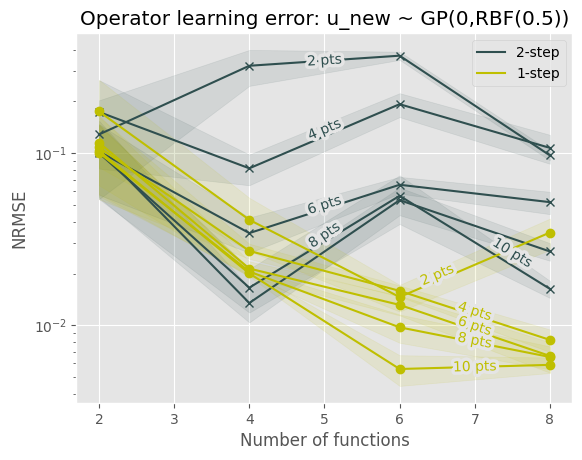

In [38]:
import matplotlib.colors as mcolors
# In sample plot
plt.title('Operator learning error: u_new ~ GP(0,RBF(0.5))')
ms = NUM_FUN_LIST
# Colors
c2 = 'darkslategrey'
c1 = 'y'
# 2-step method plot
for obs_pt in OBS_PTS_LIST:
    # 2 method
    mean_i_opt_2 = jnp.array([jnp.mean(e) for e in jnp.array(err['2_mthd'][f'{obs_pt}_obs']['i_opt'])])
    sd_i_opt_2 = jnp.array([jnp.std(e) for e in jnp.array(err['2_mthd'][f'{obs_pt}_obs']['i_opt'])])
    # Plot 2 method
    plt.plot(ms, mean_i_opt_2, label = f'{obs_pt} pts', marker= 'x', color = c2)
    plt.fill_between(ms, mean_i_opt_2 - sd_i_opt_2, mean_i_opt_2 + sd_i_opt_2, alpha=.1, color = c2)
    plt.yscale('log')
# 1-step method plot
for obs_pt in OBS_PTS_LIST:
    # 1_5 method
    mean_i_opt_1_5 = jnp.array([jnp.mean(e) for e in jnp.array(err['1_5_mthd'][f'{obs_pt}_obs']['i_opt'])])
    sd_i_opt_1_5 = jnp.array([jnp.std(e) for e in jnp.array(err['1_5_mthd'][f'{obs_pt}_obs']['i_opt'])])
    # Plot 1_5 method
    plt.plot(ms, mean_i_opt_1_5, label = f'{obs_pt} pts', marker= 'o', color = c1)
    plt.fill_between(ms, mean_i_opt_1_5 - sd_i_opt_1_5, mean_i_opt_1_5 + sd_i_opt_1_5, alpha=.1, color = c1)
    plt.yscale('log')

plt.ylabel('NRMSE')
plt.xlabel('Number of functions')
# adding labels to the plotlines
xvals_2step = [5]*4 + [7.5]
xvals_1step = [6.5]+[7]*4
xvals = xvals_2step + xvals_1step
lines = plt.gca().get_lines()
labelLines(lines, align=True, xvals = xvals)
# add legend box
legend_elements = [Line2D([0], [0], color= c2, label='2-step'),
                   Line2D([0], [0], color= c1, label='1-step')]
plt.legend(handles = legend_elements, loc = 'upper right')
plt.show()

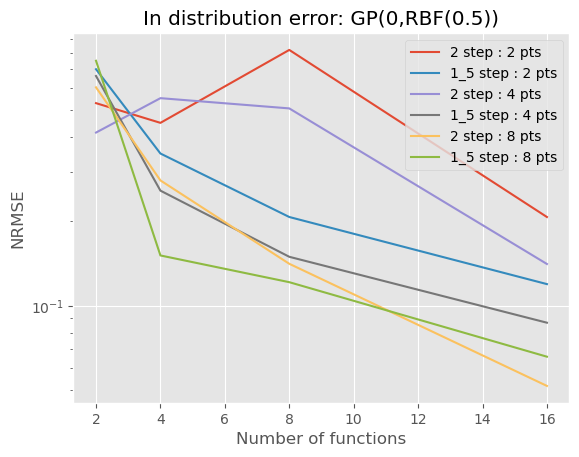

In [13]:
# In distribution plot
plt.title('In distribution error: GP(0,RBF(0.5))')
ms = NUM_FUN_LIST
OBS_PTS_LIST = [2,4,8]
for obs_pt in OBS_PTS_LIST:
    # 1_5 method
    mean_i_dis_1_5 = jnp.array([jnp.mean(e) for e in jnp.array(err['1_5_mthd'][f'{obs_pt}_obs']['i_dis'])])
    sd_i_dis_1_5 = jnp.array([jnp.std(e) for e in jnp.array(err['1_5_mthd'][f'{obs_pt}_obs']['i_dis'])])
    # 2 method
    mean_i_dis_2 = jnp.array([jnp.mean(e) for e in jnp.array(err['2_mthd'][f'{obs_pt}_obs']['i_dis'])])
    sd_i_dis_2 = jnp.array([jnp.std(e) for e in jnp.array(err['2_mthd'][f'{obs_pt}_obs']['i_dis'])])
    # Plot 2 method
    plt.plot(ms, mean_i_dis_2, label = f'2 step : {obs_pt} pts')
    plt.fill_between(ms, mean_i_dis_2 - sd_i_dis_2, mean_i_dis_2 + sd_i_dis_2, alpha=.2)
    plt.yscale('log')
    # Plot 1_5 method
    plt.plot(ms, mean_i_dis_1_5, label = f'1_5 step : {obs_pt} pts')
    plt.fill_between(ms, mean_i_dis_1_5 - sd_i_dis_1_5, mean_i_dis_1_5 + sd_i_dis_1_5, alpha=.2)
    plt.yscale('log')
plt.ylabel('NRMSE')
plt.xlabel('Number of functions')
plt.legend()
plt.show()

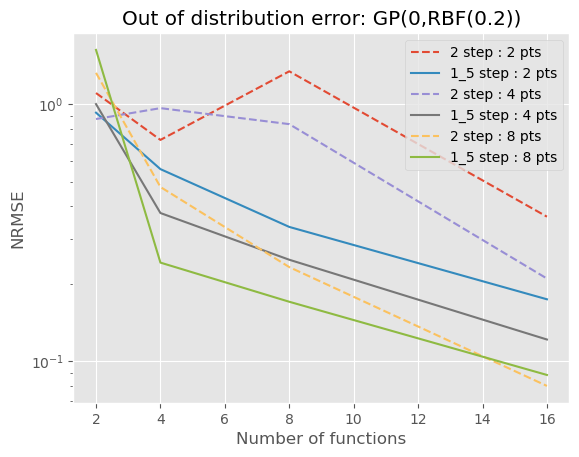

In [15]:
# Out of distribution
plt.title('Out of distribution error: GP(0,RBF(0.2))')
ms = NUM_FUN_LIST
OBS_PTS_LIST = [2,4,8]
for obs_pt in OBS_PTS_LIST:
    # 1_5 method
    mean_o_dis_1_5 = jnp.array([jnp.mean(e) for e in jnp.array(err['1_5_mthd'][f'{obs_pt}_obs']['o_dis'])])
    sd_o_dis_1_5 = jnp.array([jnp.std(e) for e in jnp.array(err['1_5_mthd'][f'{obs_pt}_obs']['o_dis'])])
    # 2 method
    mean_o_dis_2 = jnp.array([jnp.mean(e) for e in jnp.array(err['2_mthd'][f'{obs_pt}_obs']['o_dis'])])
    sd_o_dis_2 = jnp.array([jnp.std(e) for e in jnp.array(err['2_mthd'][f'{obs_pt}_obs']['o_dis'])])
    # Plot 2 method
    plt.plot(ms, mean_o_dis_2, label = f'2 step : {obs_pt} pts',ls = '--')
    plt.fill_between(ms, mean_o_dis_2 - sd_o_dis_2, mean_o_dis_2 + sd_o_dis_2, alpha=.2)
    plt.yscale('log')
    # Plot 1_5 method
    plt.plot(ms, mean_o_dis_1_5, label = f'1_5 step : {obs_pt} pts')
    plt.fill_between(ms, mean_o_dis_1_5 - sd_o_dis_1_5, mean_o_dis_1_5 + sd_o_dis_1_5, alpha=.2)
    plt.yscale('log')
plt.ylabel('NRMSE')
plt.xlabel('Number of functions')
plt.legend()
plt.show()